In [1]:
import numpy as np
from scipy import sparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.evaluate import bias_variance_decomp
import re
from nltk.corpus import stopwords
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from nltk.corpus import wordnet
from nltk.tokenize import wordpunct_tokenize
from sklearn import svm
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
from sklearn import metrics
import itertools

In [2]:
news_dataset = pd.read_csv('train.csv')
news_dataset

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


## Data Cleaning
### Missing values

In [3]:
## Checking for missing values
news_dataset.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

The number of missing values of text and title are relatively low. So these instances can be removed. The number of missing values of the author column are more than that of the columns title and text. Although they are still relatively low, so they can be filled in with the most common. 

In [4]:
news_dataset['author'].value_counts()

Pam Key                                      243
admin                                        193
Jerome Hudson                                166
Charlie Spiering                             141
John Hayward                                 140
                                            ... 
Jeremy R. Hammond                              1
Vic Bishop                                     1
Douglas Martin                                 1
Najim Rahim and Fahim Abed                     1
Michael J. de la Merced and Rachel Abrams      1
Name: author, Length: 4201, dtype: int64

In [5]:
news_dataset['author'] = news_dataset['author'].fillna("Pam Key")

In [6]:
news_dataset.loc[news_dataset['author'].isna()]

,id,title,author,text,label


In [7]:
news_dataset.isnull().sum()

id          0
title     558
author      0
text       39
label       0
dtype: int64

In [8]:
news_dataset.isnull().sum()

id          0
title     558
author      0
text       39
label       0
dtype: int64

### Detecting outliers

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label'>

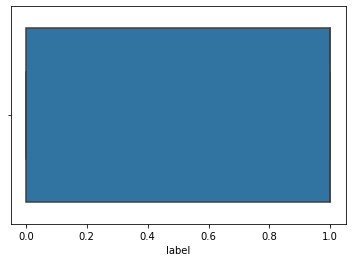

In [9]:
# Label are the only numerical values(main feature), so we check if it contains outliers.
sns.boxplot(news_dataset['label'])

It does not contain any outliers.

Next step is to create new feature out of the existing features.

In [10]:
# text word count
news_dataset['word_count'] = news_dataset['text'].apply(lambda x: len(str(x).split()))
print(news_dataset[news_dataset['label']==1]['word_count'].mean()) # fake articles
print(news_dataset[news_dataset['label']==0]['word_count'].mean()) # reliable articles

639.0722174205321
878.9965341292


In [11]:
news_dataset.head()

,id,title,author,text,label,word_count
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,820
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,710
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,1266
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,557
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,154


<AxesSubplot:>

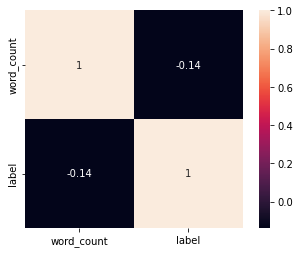

In [12]:
cols = ['word_count', 'label']
corrmat = news_dataset[cols].corr()
sns.heatmap(corrmat, square=True, annot=True)

A shown above the correlation between the reliabilty and the wordcount is very low. So we are trying a new feature.

In [13]:
news_dataset["text"] = news_dataset["text"].fillna('')
news_dataset['Avg_length'] = news_dataset["text"].apply(lambda x: np.mean([len(w) for w in x.split()]))
print(news_dataset[news_dataset['label'] == 1]['Avg_length'].mean())
print(news_dataset[news_dataset['label'] == 0]['Avg_length'].mean())

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


5.119332276011902
4.932543698593878


In [14]:
news_dataset["title"] = news_dataset["title"].fillna('')
news_dataset['title_avg_length'] = news_dataset["title"].apply(lambda x: np.mean([len(w) for w in x.split()]))

<AxesSubplot:>

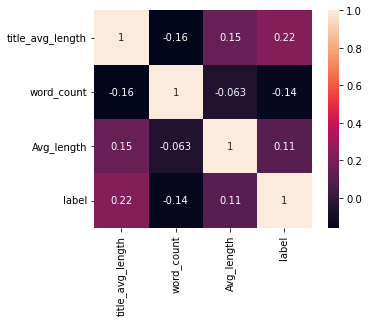

In [15]:
cols = ['title_avg_length', 'word_count', 'Avg_length', 'label']
corrmat = news_dataset[cols].corr()
sns.heatmap(corrmat, square=True, annot=True)

The average length of the text has some higher correlation than the word count feature

Now we are investigating if there is a correlation between the author and the reliability of the news.

In [16]:
news_dataset.loc[news_dataset['author'] == 'Pam Key']

,id,title,author,text,label,word_count,Avg_length,title_avg_length
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,Pam Key,Ever wonder how Britain’s most iconic pop pian...,1,489,4.570552,5.529412
8,8,Excerpts From a Draft Script for Donald Trump’...,Pam Key,Donald J. Trump is scheduled to make a highly ...,0,1440,4.670833,4.526316
20,20,News: Hope For The GOP: A Nude Paul Ryan Has J...,Pam Key,Email \nSince Donald Trump entered the electio...,1,377,4.899204,4.217391
22,22,Rob Reiner: Trump Is ’Mentally Unstable’ - Bre...,Pam Key,"Sunday on MSNBC’s “AM Joy,” actor and director...",0,206,4.237864,5.625000
23,23,Massachusetts Cop’s Wife Busted for Pinning Fa...,Pam Key,Massachusetts Cop’s Wife Busted for Pinning Fa...,1,484,4.754132,6.153846
...,...,...,...,...,...,...,...,...
20728,20728,Trump warns of World War III if Clinton is ele...,Pam Key,Email Donald Trump warned in an interview Tues...,1,773,4.870634,4.100000
20745,20745,Thomas Frank Explores Whether Hillary Clinton ...,Pam Key,Thomas Frank Explores Whether Hillary Clinton ...,1,457,4.862144,6.307692
20757,20757,Rubio on Russia Probe: ’I Wouldn’t Use the Ter...,Pam Key,Sen. Marco Rubio says he wouldn’t use the term...,0,145,4.517241,4.538462
20768,20768,Osama bin Laden’s older brother rents out luxu...,Pam Key,Osama bin Laden’s older brother rents out luxu...,1,283,5.236749,5.250000


As shown a above the most common author does not have always a real or a fake news.

## Text Preprocessing
### title + author + text

In [17]:
nltk.download('stopwords') 
nltk.download('wordnet')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emabaranauskaite/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/emabaranauskaite/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)   
    return lemmatizer.lemmatize(text)

In [19]:
news_dataset["title"] = news_dataset["title"].fillna('') 

news_dataset["article"] = news_dataset["title"] + " " + news_dataset["author"] + " " + news_dataset["text"]
news_dataset["article"] = news_dataset["article"].apply(preprocess)

In [20]:
# Most frequent words in real articles
real = news_dataset[news_dataset['label'] == 0]['article'].str.cat(sep = ' ')
list_of_words = [i.lower() for i in wordpunct_tokenize(real) if i.lower() not in stop_words and i.isalpha()]
wordfreqreal = nltk.FreqDist(list_of_words)
mostcommonreal = wordfreqreal.most_common(30)
print(mostcommonreal)

[('said', 67487), ('mr', 64512), ('trump', 37489), ('new', 25599), ('would', 22461), ('one', 22318), ('people', 19634), ('president', 16583), ('like', 15880), ('also', 15228), ('ms', 12397), ('york', 12380), ('times', 11894), ('could', 11858), ('time', 11784), ('state', 11420), ('years', 11343), ('two', 11301), ('many', 11137), ('first', 10969), ('states', 10872), ('last', 10763), ('year', 10137), ('united', 10069), ('even', 9969), ('news', 9446), ('american', 9069), ('government', 8511), ('house', 8393), ('clinton', 8349)]


In [21]:
# Most frequent words in fake articles
fake = news_dataset[news_dataset['label'] == 1]['text'].str.cat(sep = ' ')
list_of_words = [i.lower() for i in wordpunct_tokenize(fake) if i.lower() not in stop_words and i.isalpha()]
wordfreqfake = nltk.FreqDist(list_of_words)
mostcommonfake = wordfreqfake.most_common(30)
print(mostcommonfake)

[('trump', 20147), ('clinton', 19254), ('people', 16598), ('one', 16126), ('us', 14921), ('would', 14555), ('hillary', 12762), ('said', 11875), ('new', 10395), ('like', 10319), ('also', 9921), ('time', 9235), ('world', 9180), ('state', 8906), ('even', 8856), ('president', 8508), ('election', 8263), ('government', 8145), ('many', 7967), ('war', 7625), ('obama', 7547), ('could', 7448), ('american', 6976), ('u', 6936), ('russia', 6742), ('states', 6567), ('media', 6544), ('de', 6525), ('years', 6472), ('first', 6327)]


## Training 

Taking the features

In [22]:
news_dataset[["title_avg_length", "Avg_length"]] = news_dataset[["title_avg_length", "Avg_length"]].fillna(0)
word_count_avg_length = news_dataset[["title_avg_length", "Avg_length"]].values
article = news_dataset["article"].values
labels = news_dataset['label'].values

#### Splitting the dataset into training set and testing set. 

In [23]:
train_info, test_info, train_article, test_article, train_labels, test_labels = train_test_split(word_count_avg_length, article, labels, test_size=0.2)

Transforming text into numeric values

In [24]:
vectorization = TfidfVectorizer()
train_article = vectorization.fit_transform(train_article)
test_article = vectorization.transform(test_article)

In [25]:
train_data = sparse.hstack([train_article, train_info])
test_data = sparse.hstack([test_article, test_info])

In [26]:
models = {}

In [27]:
def confusionMatrix(prediction, modelName):
    cm = metrics.confusion_matrix(test_labels, prediction)

    plt.figure(figsize=(6, 6)) 

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title('Confusion matrix ' + modelName)
    plt.colorbar()

    plt.xticks(np.arange(len(['Fake', 'Real'])), ['Fake', 'Real'], rotation=45)
    plt.yticks(np.arange(len(['Fake', 'Real'])), ['Fake', 'Real'])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### 1. Logistic Regression

In [28]:
LR = LogisticRegression(solver='lbfgs', max_iter=train_data.shape[0])
LR.fit(train_data, train_labels)

LogisticRegression(max_iter=16640)

In [29]:
predictionLr = LR.predict(test_data)

In [30]:
LR.score(test_data, test_labels)

0.9560096153846154

In [31]:
models[LR] = LR.score(test_data, test_labels)

In [32]:
print(classification_report(test_labels, predictionLr))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2100
           1       0.95      0.96      0.96      2060

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



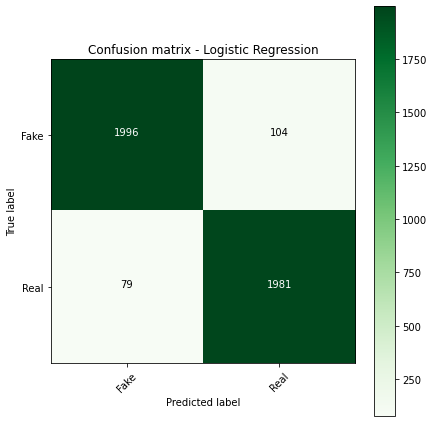

In [33]:
confusionMatrix(predictionLr, "- Logistic Regression")

In [34]:
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    fig = plt.figure()
    ax = fig.add_subplot(111, facecolor='black')
    ax.plot(m.col, m.row, 's', color='white', ms=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

In [35]:
import numpy as np
from scipy.sparse import coo_matrix
 
ax = plot_coo_matrix(test_data)
ax 

<AxesSubplot:>

### 2. Decision Tree

In [36]:
from sklearn.tree import DecisionTreeClassifier

In [37]:
DT = DecisionTreeClassifier()
DT.fit(train_data, train_labels)

DecisionTreeClassifier()

In [38]:
predictionDT = DT.predict(test_data)

In [39]:
DT.score(test_data, test_labels)

0.9701923076923077

In [40]:
models[DT] = DT.score(test_data, test_labels)

In [41]:
print(classification_report(test_labels, predictionDT))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2100
           1       0.97      0.97      0.97      2060

    accuracy                           0.97      4160
   macro avg       0.97      0.97      0.97      4160
weighted avg       0.97      0.97      0.97      4160



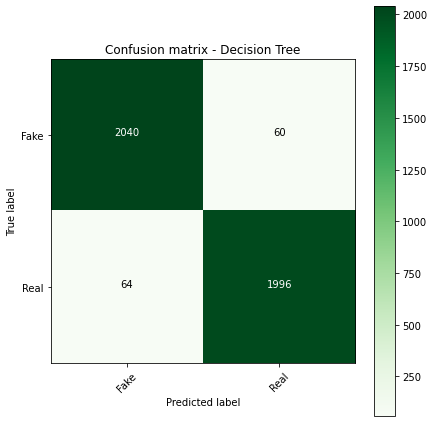

In [42]:
confusionMatrix(predictionDT, "- Decision Tree")

### 3. K-Nearest Neighbors Classifier

In [43]:
k = {}
for i in range(2,15):
    KNN = KNeighborsClassifier(n_neighbors=i)
    KNN.fit(train_data, train_labels)
    predictionKNN = KNN.predict(test_data)
    k[i] = KNN.score(test_data, test_labels)

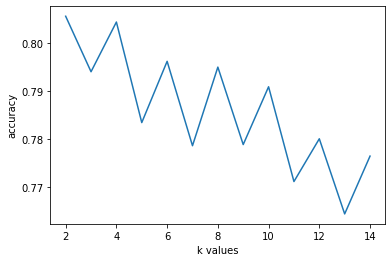

In [44]:
kval = list(k.keys())            
accuracy = list(k.values()) 
plt.xlabel("k values")
plt.ylabel("accuracy")
plt.plot(kval,accuracy) 

In [45]:
k = max(k, key=models.get)

TypeError: '>' not supported between instances of 'NoneType' and 'NoneType'

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=k)
KNN.fit(train_data, train_labels)
predictionKNN = KNN.predict(test_data) 

In [ ]:
KNN.score(test_data, test_labels)

In [ ]:
models[KNN] = KNN.score(test_data, test_labels)

In [ ]:
print(classification_report(test_labels, predictionKNN))

In [ ]:
confusionMatrix(predictionKNN, "- KNN")

### 4. Stochastic Gradient Descent

In [ ]:
SGD = SGDClassifier(random_state=0)
SGD.fit(train_data, train_labels)

In [ ]:
predictionSGD = SGD.predict(test_data)

In [ ]:
SGD.score(test_data, test_labels)

In [ ]:
models[SGD] = SGD.score(test_data, test_labels)

In [ ]:
print(classification_report(test_labels, predictionSGD))

In [ ]:
confusionMatrix(predictionSGD, "- Stochastic Gradient Descent")

### 5. SVM (Support Vector Machine)

In [ ]:
SVM = svm.SVC()
SVM.fit(train_data, train_labels)

In [ ]:
predictionSVM = SVM.predict(test_data)

In [ ]:
SVM.score(test_data, test_labels)

In [ ]:
models[SVM] = SVM.score(test_data, test_labels)

In [ ]:
print(classification_report(test_labels, predictionSVM))

In [ ]:
confusionMatrix(predictionSVM, "- SVM")

## Choosing Best Model

Reading the test.csv

In [ ]:
testdata = pd.read_csv('test.csv')

In [ ]:
testdata['author'].value_counts()

In [ ]:
testdata['author'] = testdata['author'].fillna("Pam Key")

In [ ]:
best_model = max(models, key=models.get)

In [ ]:
dict(sorted(models.items(), key=lambda item: item[1]))

In [ ]:
testdata = pd.read_csv('test.csv')
 
testdata = testdata.fillna('') 

testdata["title"] = testdata["title"].fillna('')
testdata["text"] = testdata["text"].fillna('')

In [ ]:
testdata['title_avg_length'] = testdata["title"].apply(lambda x: np.mean([len(w) for w in x.split()]))
testdata['Avg_length'] = testdata["text"].apply(lambda x: np.mean([len(w) for w in x.split()]))
testdata[["title_avg_length", "Avg_length"]] = testdata[["title_avg_length", "Avg_length"]].fillna(0)

wordCount_avgLength = testdata[["title_avg_length", "Avg_length"]].values

In [ ]:
testdata["article"] = testdata["title"] + " " + testdata["author"] + " " + testdata["text"]
testdata['article'] = testdata['article'].apply(preprocess) 
testdatavalues = testdata['article'].values  

In [ ]:
testdatavalues = vectorization.transform(testdatavalues)

In [ ]:
newcontent = sparse.hstack([testdatavalues, wordCount_avgLength])

In [ ]:
testdata['label'] = best_model.predict(newcontent)

In [ ]:
newdf = pd.DataFrame()
newdf["id"] = testdata["id"]
newdf["label"] = testdata["label"]  
display(newdf)

newdf.to_csv('submit.csv', index=False)